# Лабораторная работа 1
Выполнил: студент группы 3824М1ПМкн Бугров Андрей Викторович.
# Цель работы
Цель — изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).
# Задачи работы
Выполнение лабораторной работы предполагает решение следующих задач:

1. Изучить общую схему работы метода обратного распространения ошибки с использованием стохастического градиентного спуска.
1. Вывести математические формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
1. Загрузить набор данных MNIST, выполнить предобработку изображений и меток, если это необходимо.
1. Реализовать и протестировать метод обратного распространения ошибки для задачи классификации рукописных цифр из набора данных MNIST.



Загрузка необходимых библиотек

In [72]:
%pip install idx2numpy

In [73]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import idx2numpy

np.random.seed(42)

In [74]:
class neuralNetwork:
    def __init__(self,
                 input_neuron_count,
                 hidden_neuron_count,
                 output_neuron_count,
                 learning_rate,
                 hidden_activation_function,
                 hidden_activation_gradient,
                 output_activation_function,
                 loss_function):
        self._learning_rate = learning_rate
        self._hidden_activation_function = hidden_activation_function
        self._hidden_activation_gradient = hidden_activation_gradient
        self._output_activation_function = output_activation_function
        self._loss_function = loss_function

        scale = np.sqrt(2.0 / input_neuron_count)
        self._input_to_hidden_weights = np.random.randn(input_neuron_count, hidden_neuron_count) * scale
        self._hidden_to_output_weights = np.random.randn(hidden_neuron_count, output_neuron_count) * scale

        self._hidden_layer_offset = np.zeros((1, hidden_neuron_count))
        self._output_layer_offset = np.zeros((1, output_neuron_count))

    def predict(self, x):
        self.hidden_layer = np.dot(x, self._input_to_hidden_weights) + self._hidden_layer_offset
        self.hidden_values = self._hidden_activation_function(self.hidden_layer)

        output_layer = np.dot(self.hidden_values, self._hidden_to_output_weights) + self._output_layer_offset
        predicted_probabilities = self._output_activation_function(output_layer)
        return predicted_probabilities

    def _backpropagation(self, x, y):
        output_layer_error = (self.predict(x) - y) / x.shape[0]
        hidden_layer_error = np.dot(output_layer_error, self._hidden_to_output_weights.T) * self._hidden_activation_gradient(self.hidden_layer)

        input_to_hidden_weights_grad = np.dot(x.T, hidden_layer_error)
        output_to_hidden_weights_grad = np.dot(self.hidden_values.T, output_layer_error)

        hidden_layer_offset_grad = np.sum(hidden_layer_error, axis = 0, keepdims = True)
        output_layer_offset_grad = np.sum(output_layer_error, axis = 0, keepdims = True)

        return input_to_hidden_weights_grad, output_to_hidden_weights_grad, hidden_layer_offset_grad, output_layer_offset_grad

    def _update(self, input_to_hidden_weights_grad, output_to_hidden_weights_grad, hidden_layer_offset_grad, output_layer_offset_grad):
        # gradient descent

        self._input_to_hidden_weights -= self._learning_rate * input_to_hidden_weights_grad
        self._hidden_to_output_weights -= self._learning_rate * output_to_hidden_weights_grad

        self._hidden_layer_offset -= self._learning_rate * hidden_layer_offset_grad
        self._output_layer_offset -= self._learning_rate * output_layer_offset_grad

    def _shuffle_data(self, x, y):
        permutation_indeces = np.random.permutation(x.shape[0])
        return x[permutation_indeces], y[permutation_indeces]

    def _get_accuracy(self, predicted_probabilities, real_labels):
        predicted_classes = np.argmax(predicted_probabilities, axis=1)
        real_classes = np.argmax(real_labels, axis=1)
        return np.mean(predicted_classes == real_classes)

    def _train_one_epoch(self, train_sample, train_labels, batch_size):
        x_shuffled, y_shuffled = self._shuffle_data(train_sample, train_labels)

        for i in range(0, len(train_sample), batch_size):
            x_batch = x_shuffled[i : i + batch_size]
            y_batch = y_shuffled[i : i + batch_size]

            gradients = self._backpropagation(x_batch, y_batch)
            self._update(*gradients)

        predicted_probabilities = self.predict(train_sample)
        accuracy = self._get_accuracy(predicted_probabilities, train_labels)
        loss = self._loss_function(train_labels, predicted_probabilities)
        return accuracy, loss

    def _train_one_epoch_with_info(self, train_sample, train_labels, batch_size):
        epoch_start_time = time.time()
        accuracy, loss = self._train_one_epoch(train_sample, train_labels, batch_size)
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"\tВремя: {epoch_duration:.3f} секунд")
        print(f"\tОшибка: {loss:.5f}")
        print(f"\tТочность: {accuracy:.5f}")

    def train(self, train_sample, train_labels, epoch_count, batch_size, print_info: bool):
        for epoch in range(epoch_count):
            if print_info:
                print(f"Эпоха: {epoch + 1}")
                self._train_one_epoch_with_info(train_sample, train_labels, batch_size)
            else:
                self._train_one_epoch(train_sample, train_labels, batch_size)

    def test(self, test_sample, test_labels):
        predicted_probabilities = self.predict(test_sample)
        cross_entropy = self._loss_function(test_labels, predicted_probabilities)
        accuracy = self._get_accuracy(predicted_probabilities, test_labels)
        return cross_entropy, accuracy

In [75]:
BASE_PATH = kagglehub.dataset_download("hojjatk/mnist-dataset")

train_images = idx2numpy.convert_from_file(os.path.join(BASE_PATH, "train-images.idx3-ubyte"))
train_labels = idx2numpy.convert_from_file(os.path.join(BASE_PATH, "train-labels.idx1-ubyte"))
test_images = idx2numpy.convert_from_file(os.path.join(BASE_PATH, "t10k-images.idx3-ubyte"))
test_labels = idx2numpy.convert_from_file(os.path.join(BASE_PATH, "t10k-labels.idx1-ubyte"))
print (f"Количество изображений в тренировочной выборке: {train_images.shape[0]}, Размер изображений: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"Количество изображений в тестовой выборке: {test_images.shape[0]}. Размер изображений: {test_images.shape[1]}x{test_images.shape[2]}")

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Количество изображений в тренировочной выборке: 60000, Размер изображений: 28x28
Количество изображений в тестовой выборке: 10000. Размер изображений: 28x28


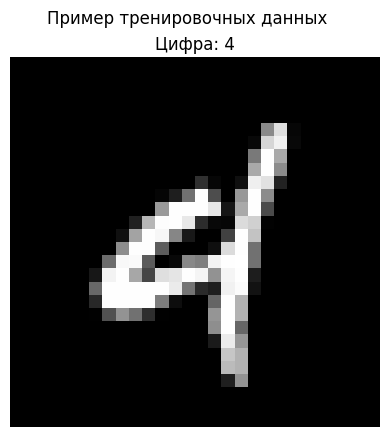

In [76]:
image_index = np.random.randint(0, len(train_images) - 1)
plt.imshow(train_images[image_index], cmap='gray')
plt.axis('off')
plt.suptitle('Пример тренировочных данных')
plt.title(f'Цифра: {train_labels[image_index]}')
plt.show()

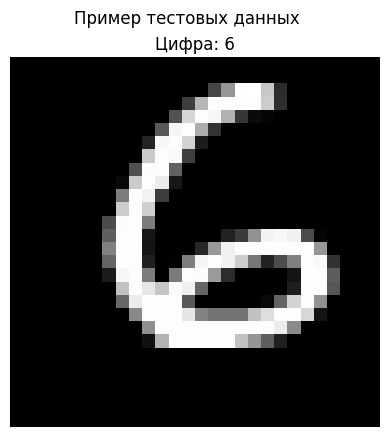

In [77]:
image_index = np.random.randint(0, len(test_images) - 1)
plt.imshow(test_images[image_index], cmap='gray')
plt.axis('off')
plt.suptitle('Пример тестовых данных')
plt.title(f'Цифра: {test_labels[image_index]}')
plt.show()

In [78]:
def ReLU(x):
    return np.maximum(0, x)

def d_ReLU(x):
    return (x > 0).astype(float)

def softmax(u):
    exp = np.exp(u - np.max(u, axis = 1, keepdims = True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))

In [79]:
INPUT_SIZE = 28 * 28
OUTPUT_SIZE = 10
HIDDEN_ACTIVATION_FUNCTION = ReLU
HIDDEN_ACTIVATION_GRADIENT = d_ReLU
OUTPUT_ACTIVATION_FUNCTION = softmax
LOSS_FUNCTION = cross_entropy
# Demonstration
LEARNING_RATE = 0.1  # Скорость движения градиентного спуска (стохастического)
HIDDEN_SIZE = 300
EPOCHS_COUNT = 20  # Полный цикл предъявления полного набора примеров (проход по всему тренировочному множеству)
BATCH_SIZE = 64

In [80]:
# Нормализация (иначе всё коту под хвост)
train_images = train_images / 255.0
test_images = test_images / 255.0
# Превращение квадратной картинки в линию
train_images = train_images.reshape(-1, INPUT_SIZE)
test_images = test_images.reshape(-1, INPUT_SIZE)

In [81]:
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

In [82]:
network = neuralNetwork(INPUT_SIZE,
                        HIDDEN_SIZE,
                        OUTPUT_SIZE,
                        LEARNING_RATE,
                        HIDDEN_ACTIVATION_FUNCTION,
                        HIDDEN_ACTIVATION_GRADIENT,
                        OUTPUT_ACTIVATION_FUNCTION,
                        LOSS_FUNCTION)
train_start_time = time.time()
network.train(train_images, train_labels, EPOCHS_COUNT, BATCH_SIZE, print_info=True)
train_end_time = time.time()
total_duration = train_end_time - train_start_time
print(f"Время обучения: {total_duration:.3f} секунд")

Эпоха: 1
	Время: 12.531 секунд
	Ошибка: 0.24406
	Точность: 0.93125
Эпоха: 2
	Время: 7.312 секунд
	Ошибка: 0.16574
	Точность: 0.95343
Эпоха: 3
	Время: 4.109 секунд
	Ошибка: 0.12890
	Точность: 0.96390
Эпоха: 4
	Время: 4.637 секунд
	Ошибка: 0.10372
	Точность: 0.97102
Эпоха: 5
	Время: 5.347 секунд
	Ошибка: 0.08860
	Точность: 0.97508
Эпоха: 6
	Время: 4.140 секунд
	Ошибка: 0.07675
	Точность: 0.97938
Эпоха: 7
	Время: 5.889 секунд
	Ошибка: 0.06123
	Точность: 0.98423
Эпоха: 8
	Время: 4.143 секунд
	Ошибка: 0.05483
	Точность: 0.98603
Эпоха: 9
	Время: 4.163 секунд
	Ошибка: 0.04839
	Точность: 0.98768
Эпоха: 10
	Время: 6.467 секунд
	Ошибка: 0.04405
	Точность: 0.98850
Эпоха: 11
	Время: 4.124 секунд
	Ошибка: 0.03839
	Точность: 0.99062
Эпоха: 12
	Время: 4.161 секунд
	Ошибка: 0.03631
	Точность: 0.99123
Эпоха: 13
	Время: 6.475 секунд
	Ошибка: 0.03111
	Точность: 0.99330
Эпоха: 14
	Время: 4.133 секунд
	Ошибка: 0.02796
	Точность: 0.99425
Эпоха: 15
	Время: 5.459 секунд
	Ошибка: 0.02613
	Точность: 0.99478
Эпо

In [83]:
test_start_time = time.time()
loss, accuracy = network.test(test_images, test_labels)
test_end_time = time.time()
duration_time = test_end_time - test_start_time
print(f"Время тестирования: {duration_time:.3f} секунд")
print(f"Ошибка: {loss:.5f}")
print(f"Точность: {accuracy:.5f}")

Время тестирования: 0.164 секунд
Ошибка: 0.06468
Точность: 0.98030


Точность составила около 98% на тестовой выборке